# CAP5610 - HW 1

In HW1, you will explore and compare Feature Extraction and Feature Selection using a high-
dimensional biological dataset. The goal is to implement Autoencoder (feature extraction) and
Concrete Autoencoder (feature selection), visualize and analyze results, and present your findings
in a structured report.
## Data:
• Gene Expression: lncRNA_5_Cancers.csv
• Cancer Types: KIRC, LUAD, LUSC, PRAD, THCA
• Features: 12,309 lncRNAs
## Tasks:
### Task 1: [25 points] Explore the Data
Load the provided dataset and see how many data points and features it has. Count how many
samples belong to each type of cancer and make a simple bar chart.
### Task 2: [25 points] Classification Using All Features Employing SVM
Use those ~12K features to train an SVM with RBF kernel. Report (i) confusion matrix for one
fold, (ii) the macro, micro, and weighted precision/recall/F1 along with the accuracy, (iii) plot
AUC-ROC and AUC-PR curve. Use 5-flod cross-validation.
### Task 3: [25 points] Autoencoder for Feature Extraction
Train an Autoencoder that reduces the features to 50 latent dimensions. Use those 50 features
to train an SVM with RBF kernel. Report (i) confusion matrix for one fold, (ii) the macro, micro,
and weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR
curve.
### Task 4: [25 points] Concrete Autoencoder for Feature Selection
Train a Concrete Autoencoder to select 50 actual features. Train an SVM with RBF kernel on
those 50 selected features. Report (i) confusion matrix for one fold, (ii) the macro, micro, and
weighted precision/recall/F1 along with the accuracy, (iii) plot AUC-ROC and AUC-PR curve.
## Hint:
• Autoencoder: You can implement a simple Autoencoder using libraries like
Keras/TensorFlow or PyTorch.
• Concrete Autoencoder: Use the concrete-autoencoder library for this task. It requires
TensorFlow 2.12.*. Install it using:
pip install tensorflow==2.12.0 concrete-autoencoder
• SVM: Use the following for reproducibility:
svm = SVC(kernel="rbf", probability=True, random_state=42)
## Submission:
You must submit the following items in CANVAS:
• Report (MS word or PDF)
o Describe the algorithms/approaches/tools used: (a) What it is or What it does, (b) How
it does, and (c) Application.
o Describe results: (a) Put Figure/Table number and Title: On top of the table, and bottom
of the figure. (b) Describe the figure and table. (c) Your observation about the figure
and table. (d) Conclusion.
• Source code (*.py or Jupyter notebook)
o Must be well organized (comments, indentation, ...)
• File name: HW1_lastName
You must submit the files SEPERATELY. DO NOT compress into a ZIP file. If you fail to
provide all required information or files, you may be given zero score without grading.
## Deadline:
The deadline is 11:59pm Wednesday, September 10, 2025. Late assignments will not be accepted.

## TASK 1
### Loading Data

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
DATA_DIR = ROOT / "data"
SPLIT_DIR = ROOT / DATA_DIR / "cv_splits"
SPLIT_DIR.mkdir(parents=True,exist_ok=True)

data_file_name = "lncRNA_5_Cancers.csv"
data_path = DATA_DIR / data_file_name

data = pd.read_csv(data_path)
print(data)

            Ensembl_ID  ENSG00000005206.15  ENSG00000083622.8  \
0     TCGA-3Z-A93Z-01A            3.390813                0.0   
1     TCGA-6D-AA2E-01A            3.144547                0.0   
2     TCGA-A3-3306-01A            2.484817                0.0   
3     TCGA-A3-3307-01A            2.789058                0.0   
4     TCGA-A3-3308-01A            3.258763                0.0   
...                ...                 ...                ...   
2524  TCGA-MK-A4N6-01A            1.996951                0.0   
2525  TCGA-MK-A4N7-01A            2.570807                0.0   
2526  TCGA-MK-A4N9-01A            3.022679                0.0   
2527  TCGA-MK-A84Z-01A            3.139110                0.0   
2528  TCGA-QD-A8IV-01A            3.014305                0.0   

      ENSG00000088970.14  ENSG00000099869.7  ENSG00000100181.20  \
0               2.918265           0.014832            0.341984   
1               1.961410           0.047186            1.677598   
2               2.

Now with the data loaded. Getting a sense of the data shape:

Class
KIRC    527
LUAD    510
THCA    501
LUSC    498
PRAD    493
Name: count, dtype: int64
Total number of data points: 2529.
Total number of features: 12311


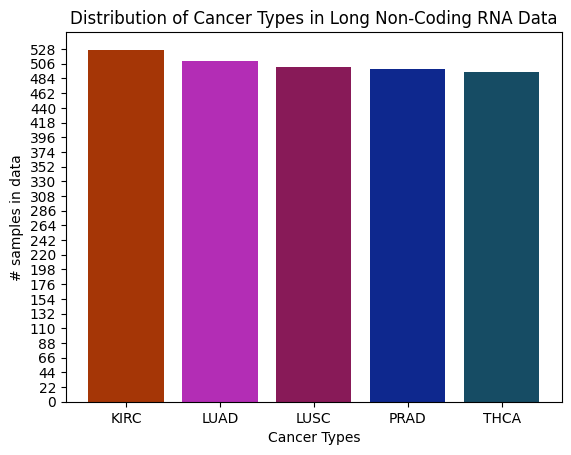

In [58]:

# Counting each cancer type
cancer_type_counts = data['Class'].value_counts()
classes = data['Class'].unique().tolist()
print(cancer_type_counts)
print(f"Total number of data points: {data.shape[0]}.\nTotal number of features: {data.shape[1]}",)

# Creating bar chart 
plt.bar(classes,cancer_type_counts,color=['#a53606', '#b32db5', '#881a58', '#0e288e', '#164c64'])
plt.xlabel("Cancer Types")
plt.ylabel("# samples in data")
plt.title("Distribution of Cancer Types in Long Non-Coding RNA Data")
plt.yticks([x for x in range(0,550,22)])
plt.show()


## Task 2

AttributeError: module 'numpy' has no attribute 'dumps'

<Figure size 640x480 with 0 Axes>

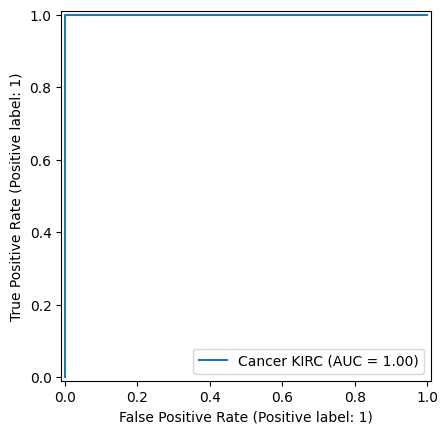

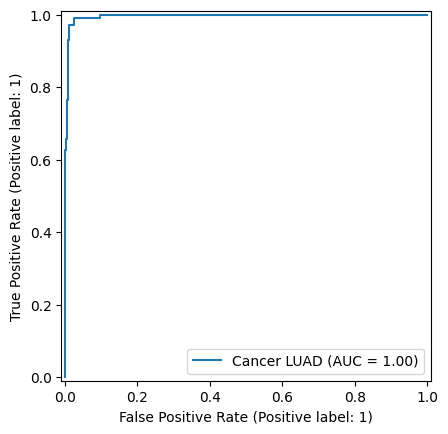

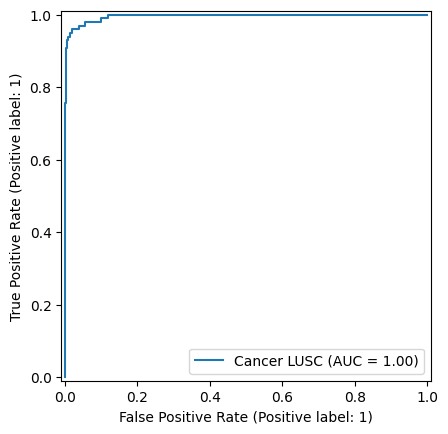

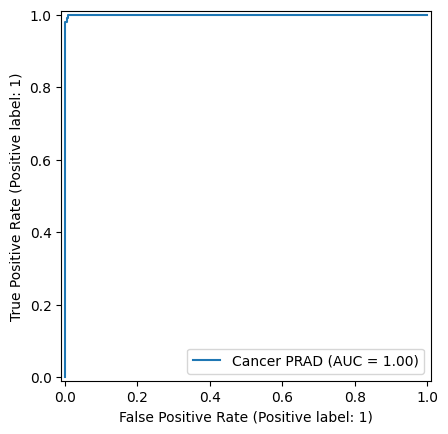

<Figure size 640x480 with 0 Axes>

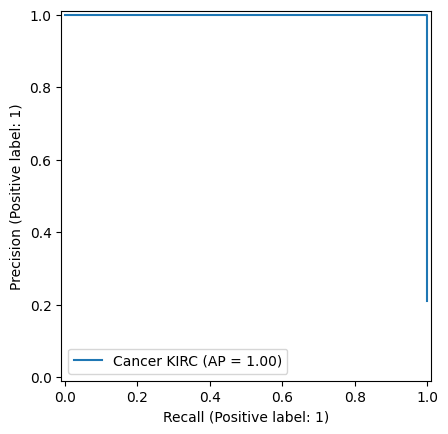

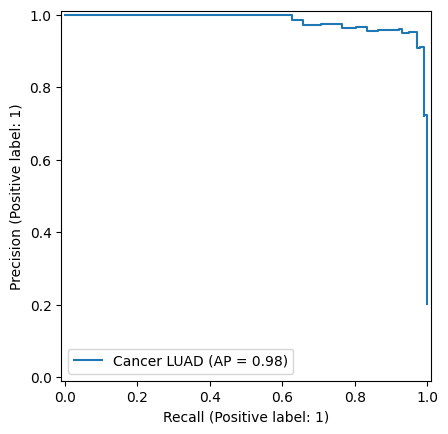

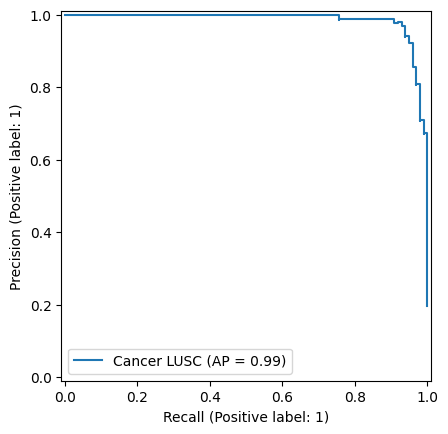

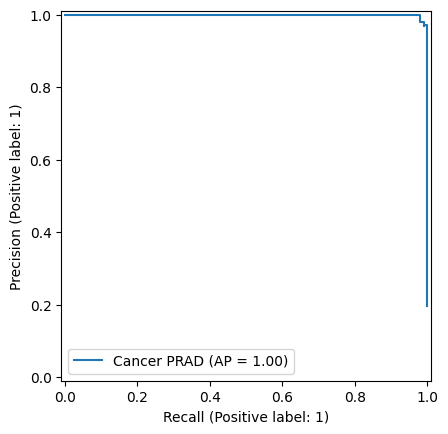

In [62]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler,label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (accuracy_score,precision_recall_fscore_support,roc_auc_score,average_precision_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay,PrecisionRecallDisplay)

# Defining output locations
OUT_METRICS = ROOT/"reports"/"metrics"
OUT_FIGS = ROOT/"reports"/"figures"
OUT_METRICS.mkdir(parents=True,exist_ok=True)
OUT_FIGS.mkdir(parents=True,exist_ok=True)

# Setting data into feature set and label set for classification
feature_set = data.to_numpy()[:,1:data.shape[1] - 1] # strips ID column and labels from data table leaving only feature set
output_labels = data.to_numpy()[:,-1] # isolates labels indexed by sample 

n_splits = 5
seed = 42
plots_fold = 2
method = "svm_full"

# Using the SKLEARN helper class to partition data for training and testing
kfold_cross = StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=seed) #given kernel, probablity, and random_state for the sake of reproducibility

# KFold Cross Validation Loop
folds = {}
results = []
k = 1
for train_idx, test_idx in kfold_cross.split(feature_set,output_labels):
    # Generate the partitions for kfold cross validation
    feature_training_set, feature_validation_set = feature_set[train_idx], feature_set[test_idx]
    training_labels, validation_labels = output_labels[train_idx], output_labels[test_idx] 

    # Store the partitions for Tasks 3 & 4
    folds[f"train_{k}"] = train_idx
    folds[f"valid_{k}"] = test_idx

    # Initializing Support Vector Machine (SVM) for classification
    model = make_pipeline(
        StandardScaler(), #This was used to ensure large variance in the magnitude of values between features didn't skew the model. This particular scalar was chosen to keep things simple though. I don't yet understand why I might change things here.
        SVC(kernel="rbf",probability=True,random_state=seed) #given kernel, probablity, and random_state for the sake of reproducibility
    )
    # Training the model on fold K
    model.fit(feature_training_set,training_labels)

    # Getting predicted classification from model
    predicted_labels = model.predict(feature_validation_set)
    predicted_probability = model.predict_proba(feature_validation_set)

    # Metrics
    ## Accuracy
    accuracy = accuracy_score(validation_labels,predicted_labels) #SKLEARN metric function that computes accuracy
    ## Macro prec/recall/f1
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="macro",zero_division=0) 
    ## Micro prec/recall/f1
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="micro",zero_division=0) 
    ## Weighted prec/recall/f1
    precision_weight, recall_weight, f1_weight, _ = precision_recall_fscore_support(validation_labels,predicted_labels,average="weighted",zero_division=0) 

    # AUC curves
    roc_auc = roc_auc_score(validation_labels,predicted_probability,average="macro",multi_class='ovr')
    bins = label_binarize(validation_labels,classes=classes)
    ap_auc = average_precision_score(bins,predicted_probability,average="macro")

    results.append({"fold":k,"accuracy":accuracy,"precision_macro":precision_macro,"recall_macro":recall_macro,"f1_macro":f1_macro,
                    "precision_micro":precision_micro,"recall_micro":recall_micro,"f1_micro":f1_micro,
                    "precision_weighted":precision_weight,"recall_weighted":recall_weight,"f1_weighted":f1_weight,
                    "roc_auc":roc_auc,"avg_precision":ap_auc
    })

    # Plotting
    if k == plots_fold:

        ## Plotting Confusion Matrix
        my_confusion_matrix = confusion_matrix(validation_labels,predicted_labels,labels=classes)
        ConfusionMatrixDisplay(my_confusion_matrix,display_labels=classes).plot(values_format="d")
        plt.title(f"{method}: Confusion Matrix (fold{k+1})")
        plt.savefig(OUT_FIGS/f"{method}_cm_fold{k}.png")
        plt.close()

        ## Plotting ROC Curve
        plt.figure()
        for i, cls in enumerate(classes):
            RocCurveDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}")
        plt.title(f"{method}: ROC (fold{k+1})")
        plt.tight_layout()
        plt.savefig(OUT_FIGS/f"{method}_roc_fold{k}.png")
        plt.close()

        ## Plotting PR
        plt.figure()
        for i, cls in enumerate(classes):
            PrecisionRecallDisplay.from_predictions(bins[:,i],predicted_probability[:,i],name=f"Cancer {cls}")
        plt.title(f"{method}: PR (OvR) (fold{k+1})")
        plt.tight_layout()
        plt.savefig(OUT_FIGS/f"{method}_pr_fold{k}.png")
        plt.close()

    k += 1

# Writing stored info to file
kfold_partition_data_path = SPLIT_DIR/f"folds_{n_splits}_seed_{seed}.npz"
np.savez(kfold_partition_data_path)

meta = {
    "n_splits": n_splits,
    "shuffle": True,
    "random_state": seed,
    "n_samples": int(len(output_labels))
}
(SPLIT_DIR/"meta.json").write_text(np.dumps(meta,indent=2))

result_df = pd.DataFrame(results).sort_values("fold")
result_df.to_csv(OUT_METRICS/f"{method}_per_fold.csv", index=False)

summary = result_df.drop(columns=["fold"]).agg(["mean","std"]).T
summary.to_csv(OUT_METRICS / f"{method}_cv_summary.csv")
print(summary)
print(f"Saved metrics → {OUT_METRICS}")
print(f"Saved figures → {OUT_FIGS}")
print(f"Saved splits  → {kfold_partition_data_path}")